In [1]:
import glob
import h5py
import numpy as np
import os
import pylab
import scipy.linalg
import scipy as sp
import sys

from numpy import array, concatenate, zeros
from numpy.random import randn
from scipy.optimize import minimize

from functools import reduce

from openfermion.config import *
from openfermionprojectq import *

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, get_sparse_operator
from openfermion.utils import uccsd_singlet_paramsize
from openfermion.ops import FermionOperator

from openfermionpsi4 import run_psi4

%matplotlib inline

hartree_to_kcal = 627.50947415

In [2]:
def canonical_eigh(M, S):
    """Return the eigenvectors and eigenvalues in the original basis with potentially singular S"""
    #Solve for spectrum with canonical orthogonalization
    overlapCutoff = 1.0e-8
    [evals, evecs] = sp.linalg.eigh(S)

    #Determine rank
    RankOverlap = np.sum(evals > overlapCutoff)
    nullity = len(evals) - RankOverlap
    #Cutoff
    evals = evals[nullity:]
    evecs = evecs[:, nullity:]

    #Make transformation matrix
    U = np.dot(evecs, np.diag(evals**(-0.5)))

    #Transform the Hamiltonian and find the new eigenvectors
    M_prime = np.dot(np.conj(U).T, np.dot(M, U))
    S_prime = np.dot(np.conj(U).T, np.dot(S, U))

    e_vals, e_vecs = sp.linalg.eigh(M_prime, S_prime)
    #Transform eigenvectors back to original basis
    e_vecs = np.dot(U, e_vecs)
    
    return e_vals, e_vecs, U

def FindSymmTransform(M, S, val):
    """Find a transform to project onto the eigenspace corresponding to eigenvalue val of operator 
    representation M with overlap S"""
    e_vals, e_vecs, U = canonical_eigh(M, S)
    indices = np.where(np.abs(e_vals-val) < 0.1)[0]
    U = e_vecs[:, indices]
    return U

In [3]:
# Load files
molecule_filenames = sorted(glob.glob('data/*.hdf5'))
test_molecule = MolecularData(filename=molecule_filenames[0])
print("Number of spatial basis functions: {}".format(test_molecule.n_orbitals))
print("Number of electrons: {}".format(test_molecule.n_electrons))
test_molecule = None

Number of spatial basis functions: 52
Number of electrons: 16


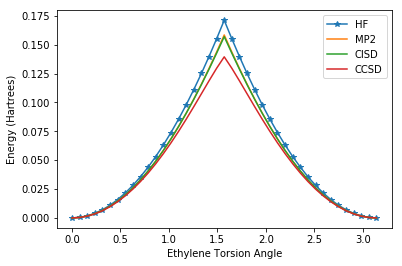

In [4]:
# Plot CCSD curve for angle
angles = []
hf_energies = []
mp2_energies = []
cisd_energies = []
ccsd_energies = []

for filename in molecule_filenames:
    angle = float(filename.split('_')[-1].rstrip('.hdf5'))
    molecule = MolecularData(filename=filename)
    
    angles.append(angle)
    hf_energies.append(molecule.hf_energy)
    mp2_energies.append(molecule.mp2_energy)
    cisd_energies.append(molecule.cisd_energy)
    ccsd_energies.append(molecule.ccsd_energy)

pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Energy (Hartrees)")
pylab.plot(angles, np.array(hf_energies) - hf_energies[0], '*-', label="HF")
pylab.plot(angles, np.array(mp2_energies) - mp2_energies[0], label="MP2")
pylab.plot(angles, np.array(cisd_energies) - cisd_energies[0], label="CISD")
pylab.plot(angles, np.array(ccsd_energies) - ccsd_energies[0], label="CCSD")
pylab.legend()

Qubit Hamiltonian Matrix
[[-76.86638025+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04891685+0.j]]

Energy: -78.04891684583123	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.86759778+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04847427+0.j]]

Energy: -78.04847426828763	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.87112449+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04714686+0.j]]

Energy: -78.04714686089714	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.87662076+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04493561+0.j]]

Energy: -78.04493561435751	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.88362529+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.04184223+0.j]]

Energy: -78.04184222696486	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.89165449+0.j   0.00000000+0.j]
 [  0.00000000+0.j -78.03786917+0.j]]

Energy: -78.03786916696703	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.90027299+0.j   

Energy: -78.0594207637029	 Number: (1.9999999999999996+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.88362529+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j -77.54477256+0.j   0.00000000+0.j   0.08547376+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j -77.72659535+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.08547376+0.j   0.00000000+0.j -78.04184223+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
  -77.42906485+0.j]]

Energy: -78.05612924707025	 Number: (1.9999999999999998+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-76.89165449+0.j   0.00000000+0.j   0.00000000+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j -77.56044884+0.j   0.00000000+0.j   0.08329680+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.00000000+0.j -77.73350753+0.j   0.00000000+0.j
    0.00000000+0.j]
 [  0.00000000+0.j   0.08329680+0.j   0.00000000+0.j -78.03786917+0.j
    0.000

Energy: -77.95338441210059	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69791969e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.78222475e+01+0.j   0.00000000e+00+0.j
    6.62173968e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.78062656e+01+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   6.62173968e-02+0.j   0.00000000e+00+0.j
   -7.79092428e+01+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j  -7.74488925e+01+0.j]]

Energy: -77.94497134845615	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69817178e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.78405100e+01+0.j   0.00000000e+00+0.j
    6.60802623e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.78074510e+01+0


Energy: -78.01979227303362	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69265243e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.76379027e+01+0.j   0.00000000e+00+0.j
    7.48695490e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.77638671e+01+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   7.48695490e-02+0.j   0.00000000e+00+0.j
   -7.80132609e+01+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j  -7.74404643e+01+0.j]]

Energy: -78.0276434147554	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[ -7.69179425e+01+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -7.76171833e+01+0.j   0.00000000e+00+0.j
    7.67774070e-02+0.j   0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j  -7.77563830e+01+0

Qubit Hamiltonian Matrix
[[ -7.70197957e+01+0.j   6.66537792e-18+0.j  -3.58983091e-24+0.j ...,
   -5.15268601e-25+0.j   4.35860795e-03+0.j   2.39101678e-03+0.j]
 [  6.66537792e-18+0.j  -7.66873595e+01+0.j   2.46797183e-03+0.j ...,
    6.05550725e-06+0.j  -7.14131555e-15+0.j   2.91029656e-03+0.j]
 [ -3.58983091e-24+0.j   2.46797183e-03+0.j  -7.67974336e+01+0.j ...,
    4.05042739e-05+0.j   1.41950816e-19+0.j  -5.12486116e-03+0.j]
 ..., 
 [ -5.15268601e-25+0.j   6.05550725e-06+0.j   4.05042739e-05+0.j ...,
   -7.69814103e+01+0.j   5.59298635e-22+0.j   5.21451612e-04+0.j]
 [  4.35860795e-03+0.j  -7.14131555e-15+0.j   1.41950816e-19+0.j ...,
    5.59298635e-22+0.j  -7.71961426e+01+0.j   2.26277496e-15+0.j]
 [  2.39101678e-03+0.j   2.91029656e-03+0.j  -5.12486116e-03+0.j ...,
    5.21451612e-04+0.j   2.26277496e-15+0.j  -7.68963278e+01+0.j]]

Energy: -78.0601458918211	 Number: (3.9999999999999987+0j)	 Sz:(-6.298986696732369e-35+0j)	 S^2:(6.926542023291186e-34+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.69513408e+01+0.j   6.67078883e-18+0.j   5.03830754e-23+0.j ...,
   -1.18834744e-24+0.j   2.32328952e-03+0.j   2.29864314e-03+0.j]
 [  6.67078883e-18+0.j  -7.67479886e+01+0.j   4.83579153e-03+0.j ...,
    1.39656220e-05+0.j  -7.14702033e-15+0.j   2.26923086e-03+0.j]
 [  5.03830754e-23+0.j   4.83579153e-03+0.j  -7.68137042e+01+0.j ...,
    3.73521977e-05+0.j   2.54219919e-19+0.j  -1.12258240e-02+0.j]
 ..., 
 [ -1.18834744e-24+0.j   1.39656220e-05+0.j   3.73521977e-05+0.j ...,
   -7.70431363e+01+0.j   1.28989249e-21+0.j   1.11558627e-03+0.j]
 [  2.32328952e-03+0.j  -7.14702033e-15+0.j   2.54219919e-19+0.j ...,
    1.28989249e-21+0.j  -7.72046216e+01+0.j   1.20628527e-15+0.j]
 [  2.29864314e-03+0.j   2.26923086e-03+0.j  -1.12258240e-02+0.j ...,
    1.11558627e-03+0.j   1.20628527e-15+0.j  -7.69066694e+01+0.j]]

Energy: -78.00572524844853	 Number: (4.000000000000001+0j)	 Sz:(-4.112676582721609e-34+0j)	 S^2:(4.484898203494595e-33+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.68803324e+01+0.j   6.67596842e-18+0.j  -1.51902347e-23+0.j ...,
   -1.20959318e-24+0.j   1.68961723e-03+0.j   2.21875866e-03+0.j]
 [  6.67596842e-18+0.j  -7.68062837e+01+0.j   5.64172639e-03+0.j ...,
    1.42153048e-05+0.j  -7.15249590e-15+0.j   2.08666503e-03+0.j]
 [ -1.51902347e-23+0.j   5.64172639e-03+0.j  -7.68238900e+01+0.j ...,
    3.60143816e-05+0.j   3.27405951e-19+0.j  -1.19449821e-02+0.j]
 ..., 
 [ -1.20959318e-24+0.j   1.42153048e-05+0.j   3.60143816e-05+0.j ...,
   -7.70650967e+01+0.j   1.31295369e-21+0.j   1.16600175e-03+0.j]
 [  1.68961723e-03+0.j  -7.15249590e-15+0.j   3.27405951e-19+0.j ...,
    1.31295369e-21+0.j  -7.71934447e+01+0.j   8.77364974e-16+0.j]
 [  2.21875866e-03+0.j   2.08666503e-03+0.j  -1.19449821e-02+0.j ...,
    1.16600175e-03+0.j   8.77364974e-16+0.j  -7.69191164e+01+0.j]]

Energy: -77.94092496581273	 Number: (4.000000000000001+0j)	 Sz:(-4.1948257630201255e-34+0j)	 S^2:(4.5877136160199444e-33+0j)
Qubit Hamiltonian Matrix


Qubit Hamiltonian Matrix
[[ -7.69686516e+01+0.j   6.66927690e-18+0.j   4.28511577e-23+0.j ...,
   -1.13061156e-24+0.j   2.67362722e-03+0.j   2.32373988e-03+0.j]
 [  6.66927690e-18+0.j  -7.67309883e+01+0.j   4.69341780e-03+0.j ...,
    1.32871021e-05+0.j  -7.14542292e-15+0.j   2.37796653e-03+0.j]
 [  4.28511577e-23+0.j   4.69341780e-03+0.j  -7.68091366e+01+0.j ...,
    3.79557185e-05+0.j   2.49255228e-19+0.j  -1.07411367e-02+0.j]
 ..., 
 [ -1.13061156e-24+0.j   1.32871021e-05+0.j   3.79557185e-05+0.j ...,
   -7.70308450e+01+0.j   1.22722305e-21+0.j   1.07401357e-03+0.j]
 [  2.67362722e-03+0.j  -7.14542292e-15+0.j   2.49255228e-19+0.j ...,
    1.22722305e-21+0.j  -7.72039303e+01+0.j   1.38813742e-15+0.j]
 [  2.32373988e-03+0.j   2.37796653e-03+0.j  -1.07411367e-02+0.j ...,
    1.07401357e-03+0.j   1.38813742e-15+0.j  -7.69021075e+01+0.j]]

Energy: -78.02283693916425	 Number: (4.000000000000003+0j)	 Sz:(-3.4578911568441524e-34+0j)	 S^2:(3.86598495880059e-33+0j)
Qubit Hamiltonian Matrix
[[

Qubit Hamiltonian Matrix
[[ -7.70271846e+01+0.j   6.66498545e-18+0.j  -2.65932410e-24+0.j ...,
   -1.81682252e-25+0.j   4.66190549e-03+0.j   2.39796345e-03+0.j]
 [  6.66498545e-18+0.j  -7.66830087e+01+0.j   8.89491419e-04+0.j ...,
    2.13515474e-06+0.j  -7.14090442e-15+0.j   3.00640562e-03+0.j]
 [ -2.65932410e-24+0.j   8.89491419e-04+0.j  -7.67965637e+01+0.j ...,
    4.09274492e-05+0.j   5.17299485e-20+0.j  -1.82079460e-03+0.j]
 ..., 
 [ -1.81682252e-25+0.j   2.13515474e-06+0.j   4.09274492e-05+0.j ...,
   -7.69738237e+01+0.j   1.97207118e-22+0.j   1.85632278e-04+0.j]
 [  4.66190549e-03+0.j  -7.14090442e-15+0.j   5.17299485e-20+0.j ...,
    1.97207118e-22+0.j  -7.71948430e+01+0.j   2.42021040e-15+0.j]
 [  2.39796345e-03+0.j   3.00640562e-03+0.j  -1.82079460e-03+0.j ...,
    1.85632278e-04+0.j   2.42021040e-15+0.j  -7.68973808e+01+0.j]]

Energy: -78.06353807632235	 Number: (4.0000000000000036+0j)	 Sz:(-7.77125914788307e-36+0j)	 S^2:(9.047308991294856e-35+0j)
Qubit Hamiltonian Matrix
[[

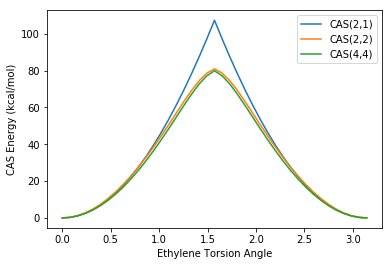

In [5]:
# Examine a CAS(n electrons, n spatial orbitals) active space - 2 x number spatial orbitals = qubits
angles = [float(filename.split('_')[-1].rstrip('.hdf5')) for filename in molecule_filenames]
cas_energies = {}
original_electrons = 16
for n_electrons, n_orbitals in [(2,1), (2,2), (4,4)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = get_sparse_operator(jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))).todense()
    spinx_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spiny_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), -0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spinz_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spin2_operator = (np.dot(spinx_operator, spinx_operator) +
                      np.dot(spiny_operator, spiny_operator) +
                      np.dot(spinz_operator, spinz_operator))
    cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    for filename in molecule_filenames:
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # Build qubit Hamiltonian
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

        # Build matrix representation & diagonalize
        qubit_hamiltonian_matrix = get_sparse_operator(hamiltonian).todense()

        # Project to S^2 = 0 subspace
        U_s2 = FindSymmTransform(spin2_operator, 
                                 np.eye(spin2_operator.shape[0]),
                                 0.0)
        qubit_hamiltonian_matrix = np.dot(np.conj(U_s2).T, np.dot(qubit_hamiltonian_matrix, U_s2))
        
        print('Qubit Hamiltonian Matrix')
        print(qubit_hamiltonian_matrix)
        print()
        
        eigvals, eigvecs = scipy.linalg.eigh(qubit_hamiltonian_matrix)
        ground_state = eigvecs[:,0][:, np.newaxis]
        energy = eigvals[0]
        number = reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, number_operator, U_s2, ground_state))[0,0]
        spinz =  reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, spinz_operator, U_s2, ground_state))[0,0]
        spin2 =  reduce(np.dot,
                       (np.conj(ground_state.T), np.conj(U_s2).T, spin2_operator, U_s2, ground_state))[0,0]
        
        cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(energy)
        print('Energy: {}\t Number: {}\t Sz:{}\t S^2:{}'.format(energy, number, spinz, spin2))
        
    
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("CAS Energy (kcal/mol)")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

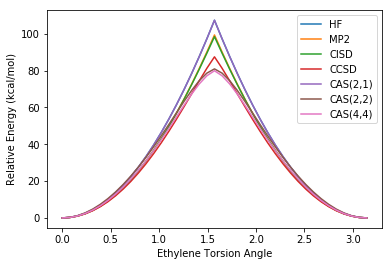

In [6]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

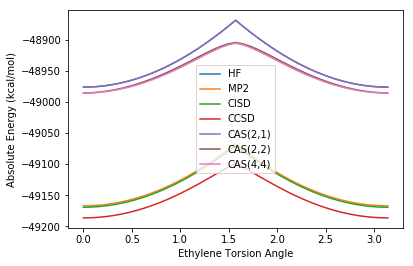

In [7]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Absolute Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * np.array(hf_energies), label="HF")
pylab.plot(angles, hartree_to_kcal * np.array(mp2_energies), label="MP2")
pylab.plot(angles, hartree_to_kcal * np.array(cisd_energies), label="CISD")
pylab.plot(angles, hartree_to_kcal * np.array(ccsd_energies), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * np.array(cas_energies[key]),
               label=key)
pylab.legend()

In [11]:
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from grove.pyvqe.vqe import VQE

from pyquil.quil import Program
import pyquil.api as api
from pyquil.gates import *
qvm = api.QVMConnection()

vqe_inst = VQE(minimizer=minimize,
               minimizer_kwargs={'method': 'l-bfgs-b'})

original_electrons = 16
n_electrons = 2
n_orbitals = 2
occupied_indices = range(8 - n_electrons // 2)
active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
active_electrons = original_electrons - len(occupied_indices) * 2
active_qubits = len(active_indices) * 2

# Define a qubit number operator
number_operator = jordan_wigner(
    sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
number_operator.compress()
spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                    for i in range(active_qubits // 2)], FermionOperator()) +
                               sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                    for i in range(active_qubits // 2)], FermionOperator()))

current_amplitudes = 0.0 + 0.001 * randn(1)
    
# Printout formatting
mini_energies = []
mini_amplitudes = []

for file_index, filename in enumerate(molecule_filenames):
    print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
    molecule = MolecularData(filename=filename)
            
    # Extract active space integrals
    hamiltonian = (molecule.
                   get_molecular_hamiltonian(
                   occupied_indices=occupied_indices,
                   active_indices=active_indices))
    fermion_hamiltonian = get_fermion_operator(hamiltonian)

    # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components and print
    qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
    qubit_hamiltonian.compress()
    #print('Jordan-Wigner')
    #print(qubit_hamiltonian)
    forest_qubit_hamiltonian = qubitop_to_pyquilpauli(qubit_hamiltonian)
    #print(forest_qubit_hamiltonian)
        
    def energy_objective(packed_amplitudes):
        """Evaluate the energy of a mini singlet wavefunction with packed_amplitudes
            Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                amplitudes

            Returns:
                energy(float): Energy corresponding to the given amplitudes
        """
            
        p = Program()

        # Set Jordan-Wigner initial state with correct number of electrons 
        for i in range(active_electrons):
            p.inst(X(i))

        # Build the circuit and act it on the wavefunction
        # Apply Hadamard gate to all qubits
        for i in range(active_qubits-1):
            p.inst(H(i))

        # Apply Rx on target qubit
        p.inst(RX(-np.pi/2,3))

        # Entangle qubits with CNOTs
        for i in range(active_qubits-1):
            p.inst(CNOT(i,i+1))
            
        # UCCSD exponent rotation Rz
        p.inst(RZ(packed_amplitudes[0],3))

        # Reverse CNOTs
        for i in reversed(range(active_qubits-1)):
            p.inst(CNOT(i,i+1))

        # Undo Hadamard
        for i in range(active_qubits-1):
            p.inst(H(i))

        # Rotate the one qubit back with -Rx
        p.inst(RX(np.pi/2,3))
        
        energy = vqe_inst.expectation(p, forest_qubit_hamiltonian, None, qvm)
            
        return energy

    initial_energy = energy_objective(current_amplitudes)
    
    # Run VQE Optimization to find new CCSD parameters
    opt_result = minimize(energy_objective, current_amplitudes,
                          method="l-bfgs-b", options={'disp':True})
        
    #opt_result = vqe_inst.vqe_run(energy_objective, forest_qubit_hamiltonian, current_amplitudes, None, qvm=qvm, disp='True')

    opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

    # Use previous interation as guess for next iteration
    current_amplitudes = opt_amplitudes[:]

    # Store energy and amplitudes
    mini_energies.append(opt_energy)
    mini_amplitudes.append([opt_amplitudes])

    print("\nInitial Energy: {}".format(initial_energy))
    print("Optimal mini Singlet Energy: {}".format(opt_energy))
    print("Optimal mini Singlet Amplitudes: {}".format(opt_amplitudes))
    print("Exact FCI Energy: {} Hartrees".format(
           cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))

Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5

Initial Energy: -78.04872134417654
Optimal mini Singlet Energy: -78.06376216517323
Optimal mini Singlet Amplitudes: [ 0.32551175]
Exact FCI Energy: -78.06376216517877 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.07854.hdf5

Initial Energy: -78.06327274238134
Optimal mini Singlet Energy: -78.06327275227102
Optimal mini Singlet Amplitudes: [ 0.32575134]
Exact FCI Energy: -78.06327275237307 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.15708.hdf5

Initial Energy: -78.06181550312012
Optimal mini Singlet Energy: -78.06181561266682
Optimal mini Singlet Amplitudes: [ 0.32657092]
Exact FCI Energy: -78.06181561338613 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.23562.hdf5

Initial Energy: -78.0594203357498
Optimal mini Singlet Energy: -78.0594207636953
Optimal mini Singlet Amplitudes: [ 0.32834017]
Exact FCI Energy: -78.0594207637029 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_

Optimal mini Singlet Energy: -78.04702857888921
Optimal mini Singlet Amplitudes: [ 0.34226537]
Exact FCI Energy: -78.04702857896379 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_2.74889.hdf5

Initial Energy: -78.05197944114671
Optimal mini Singlet Energy: -78.05198483213967
Optimal mini Singlet Amplitudes: [ 0.33572056]
Exact FCI Energy: -78.05198483216594 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_2.82743.hdf5

Initial Energy: -78.05612660856194
Optimal mini Singlet Energy: -78.05612924706519
Optimal mini Singlet Amplitudes: [ 0.33123375]
Exact FCI Energy: -78.05612924706993 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_2.90597.hdf5

Initial Energy: -78.05941963446035
Optimal mini Singlet Energy: -78.05942076367505
Optimal mini Singlet Amplitudes: [ 0.32836209]
Exact FCI Energy: -78.05942076370337 Hartrees
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_2.98451.hdf5

Initial Energy: -78.06181520342187
Optimal mini Singlet Energy: -78

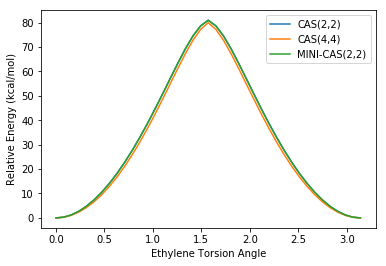

In [13]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)                     
pylab.plot(angles, 
            hartree_to_kcal * (np.array(mini_energies) - mini_energies[0]),
            label="MINI-CAS(2,2)")    
pylab.legend()
pylab.savefig("Ethylene_2_2_MINI_4Qubit.pdf")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


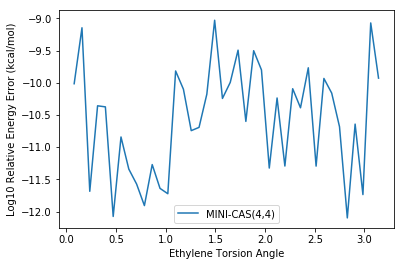

In [14]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Log10 Relative Energy Error (kcal/mol)")                     
pylab.plot(angles, 
            np.log10(np.abs((np.array(mini_energies) - mini_energies[0])- 
                            (np.array(cas_energies["CAS(2,2)"]) - cas_energies["CAS(2,2)"][0]))),
            label="MINI-" + key)
pylab.legend()
pylab.savefig("Ethylene_MINI_Err_4Qubit.pdf")